In [1]:
import numpy as np 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.modeling.powerlaws import SmoothlyBrokenPowerLaw1D as sbpl

In [2]:
def msbpl(x, amp, xb, a1, a2):
    s = 10
    return amp*((x/xb)**(-a1*s) + (x/xb)**(-a2*s))**(-1/s)
def dsbpl(x,amp,xb1,a1,a2,xb2,a3,s):
    if (a3 < a1) & (a1 < a2):
        result =  amp*(((x/xb1)**(a1*s) + (x/xb1)**(a2*s))**(-1) + (xb2/xb1)**(-a2*s)*(x/xb2)**(-a3*s))**(-1/s)
    elif (a3 < a2) & (a2 < a1):
        result = amp*((x/xb1)**(-a1*s) + (x/xb1)**(-a2*s) + ((xb1/xb2)**(a2*s))*((x/xb2)**(-a3*s)) )**(-1/s)
    else:
        raise Exception("Unhandled powerlaw index ordering")
    return result
def combinedPL(ivar, f0, nu0_1, nu0_2, nu0_3, k):
    t, nu = ivar
    s=10
    res = []
    t0 = 1
    p=2
    a1 = -k/(2*(4-k))
    b1 = -(3*k)/(5*(4-k))
    b2 = -3/2
    b3 = -(4-3*k)/(2*(4-k)) 
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        nua = nu0_1*(tval/t0)**b1
        num = nu0_2*(tval/t0)**b2
        nuc = nu0_3*(tval/t0)**b3
        if nuval < nua:
            c1 = 2 
            c2 = 1/3
            c3 = -(p-1)/2
            fpk = fnu_m*(nua/num)**(1/3)
            result = dsbpl(nuval,fpk,nua,c1,c2,num,c3,s)
        else:
            c1 = 1/3
            c2 = -(p-1)/2
            c3 = -(p-1)/2 - 0.1
            fpk = fnu_m
            result = dsbpl(nuval,fpk,num,c1,c2,nuc,c3,s)
        res.append(result)
    return np.array(res)
def wrap_sbpl(t,amp, tb, a1, a2):
    d=0.2
    f = sbpl(amplitude=amp, x_break=tb, alpha_1=-a1, alpha_2=-a2, delta=d)
    return f(t)


-1.125 -0.6 -1.875 -1.875
22.604955570292205 1.2508041336776005e-10 0.3171273746166824 1.7041045294634015e-16 0.5019081071309255 7.162196957895007e-16 -0.504896082737887 6.100853670347886e-16


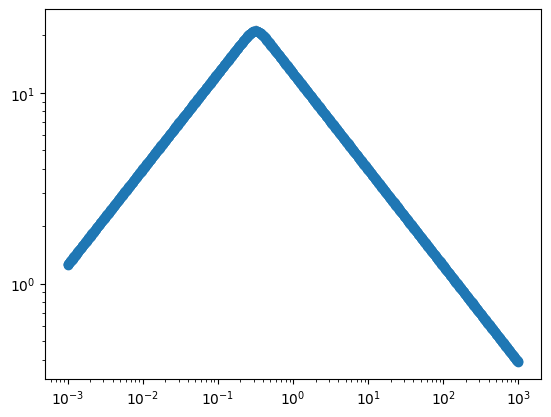

In [3]:
def combinedPL(ivar, f0, nu0_1, nu0_2, nu0_3, k):
    t, nu = ivar
    s=10
    res = []
    t0 = 1
    p=2
    a1 = -(47-10*k)/(12*(4-k))
    b1 = -(32-7*k)/(15*(4-k))
    b2 = -(73-14*k)/(12*(4-k))
    b3 = -(73-14*k)/(12*(4-k))
    print(a1,b1,b2,b3)
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        nua = nu0_1*(tval/t0)**b1
        num = nu0_2*(tval/t0)**b2
        nuc = nu0_3*(tval/t0)**b3
        if nuval < nua:
            c1 = 2 
            c2 = 1/3
            c3 = -(p-1)/2
            fpk = fnu_m*(nua/num)**(1/3)
            result = dsbpl(nuval,fpk,nua,c1,c2,num,c3,s)
        else:
            c1 = 1/3
            c2 = -(p-1)/2
            c3 = -(p-1)/2 - 0.1
            fpk = fnu_m
            result = dsbpl(nuval,fpk,num,c1,c2,nuc,c3,s)
        res.append(result)
    return np.array(res)



fig = plt.figure()
t = np.geomspace(1e-3,1e3,num=10000)
nu = np.full(t.shape,20)
ivar = (t,nu)
y = combinedPL(ivar, 1e3, 10, 1e7,1e9,2)
# def powerlaw(x,f0,a1):
#     x_break=1
#     return f0*(x/x_break)**a1
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
initial_guess = [y.max(),np.median(t),0.5,-0.5]
bounds = [(1e-6,1e6),(t.min(),t.max()),(-10,10),(-10,10)]
bounds0 = tuple([b[0] for b in bounds])
bounds1 = tuple([b[1] for b in bounds])
bounds = [bounds0,bounds1]

popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
plt.scatter(t,y,color='black',s=0.1, alpha=0.05)
plt.scatter(t[::10], msbpl(t[::10],*popt))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close()

Note that the above plot fits theoretical expectations when nu < nu_a. It is confirmed to not fit expectations when nu > nu_a. Have Alexander confirm that his values are correct for these regimes. I have only tested the ISM medium thus far. 

1000.0 2.856734680111789e-60 0.6299605249474366 6.984619119839567e-72 0.5 4.241331728908467e-72 -0.75 2.447637926013188e-71


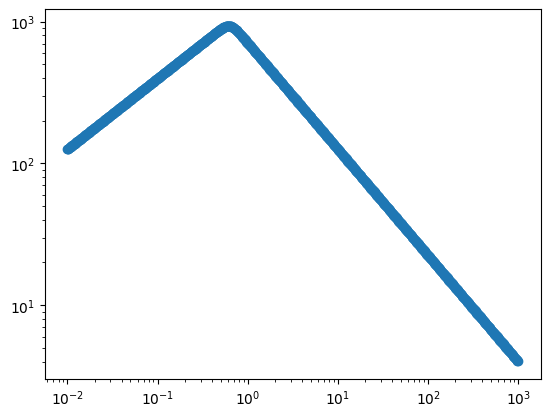

In [4]:
def msbpl(x, amp, xb, a1, a2):
    s = 10
    return amp*((x/xb)**(-a1*s) + (x/xb)**(-a2*s))**(-1/s)
def dsbpl(x,amp,xb1,a1,a2,xb2,a3,s):
    if (a3 < a1) & (a1 < a2):
        result =  amp*(((x/xb1)**(a1*s) + (x/xb1)**(a2*s))**(-1) + (xb2/xb1)**(-a2*s)*(x/xb2)**(-a3*s))**(-1/s)
    elif (a3 < a2) & (a2 < a1):
        result = amp*((x/xb1)**(-a1*s) + (x/xb1)**(-a2*s) + ((xb1/xb2)**(a2*s))*((x/xb2)**(-a3*s)) )**(-1/s)
    else:
        raise Exception("Unhandled powerlaw index ordering")
    return result
def combinedPL(ivar, f0, nu0_1, nu0_2, a1, b1, b2, c1):
    t, nu = ivar
    s=10
    res = []
    t0 = 1
    c2 = -0.5
    c3 = -1
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        num = nu0_1*(tval/t0)**b1
        nuc = nu0_2*(tval/t0)**b2
        fpk = fnu_m
        
        result = dsbpl(nuval,fpk,num,c1,c2,nuc,c3,s)
        res.append(result)
    return np.array(res)
def wrap_sbpl(t,amp, tb, a1, a2):
    d=0.2
    f = sbpl(amplitude=amp, x_break=tb, alpha_1=-a1, alpha_2=-a2, delta=d)
    return f(t)

fig = plt.figure()
t = np.geomspace(1e-2,1000,num=10000)
nu = np.full(t.shape,20)
ivar = (t,nu)
y = combinedPL(ivar, 1e3, 10, 1e9, 0, -3/2, -1/2, 1/3)
# def powerlaw(x,f0,a1):
#     x_break=1
#     return f0*(x/x_break)**a1
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
initial_guess = [1e3,1,0.5,-1]
bounds = [(1,1e6),(t.min(),t.max()),(-0.01,2),(-4,-0.01)]
bounds0 = tuple([b[0] for b in bounds])
bounds1 = tuple([b[1] for b in bounds])
bounds = [bounds0,bounds1]

popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
plt.scatter(t,y,color='black',s=0.1, alpha=0.05)
plt.scatter(t[::10], msbpl(t[::10],*popt))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close()

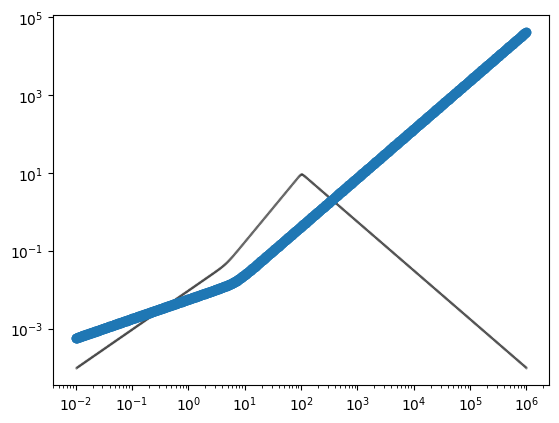

In [5]:
def msbpl(x, amp, xb, a1, a2):
    s = 10
    return amp*((x/xb)**(-a1*s) + (x/xb)**(-a2*s))**(-1/s)
def dsbpl(x,amp,xb1,a1,a2,xb2,a3,s):
    if (a3 < a1) & (a1 < a2):
        result =  amp*(((x/xb1)**(a1*s) + (x/xb1)**(a2*s))**(-1) + (xb2/xb1)**(-a2*s)*(x/xb2)**(-a3*s))**(-1/s)
    elif (a3 < a2) & (a2 < a1):
        result = amp*((x/xb1)**(-a1*s) + (x/xb1)**(-a2*s) + ((xb1/xb2)**(a2*s))*((x/xb2)**(-a3*s)) )**(-1/s)
    else:
        raise Exception("Unhandled powerlaw index ordering")
    return result
def combinedPL(ivar, f0, nu0_1, nu0_2,k):
    t, nu = ivar
    s=10
    res = []
    t0 = 1
    p=2
    a1 = -k/(2*(4-k))
    b1 = -3/2
    b2 = -(12*p+8-3*p*k+2*k)/(2*(4-k)*(p+4))
    c1= 2
    c2 = 5/2
    c3 = -(p-1)/2
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        num = nu0_1*(tval/t0)**b1
        nua = nu0_2*(tval/t0)**b2
        fpk = fnu_m*(num/nua)**(3) # actually 5/2 + (p-1)/2
        result = dsbpl(nuval,fpk,num,c1,c2,nua,c3,s)
        res.append(result)
    return np.array(res)
def wrap_sbpl(t,amp, tb, a1, a2):
    d=0.2
    f = sbpl(amplitude=amp, x_break=tb, alpha_1=-a1, alpha_2=-a2, delta=d)
    return f(t)

fig = plt.figure()
t = np.geomspace(1e-2,1e6,num=10000)
nu = np.full(t.shape,1)
ivar = (t,nu)
y = combinedPL(ivar, 1e3, 10, 100,2)
# def powerlaw(x,f0,a1):
#     x_break=1
#     return f0*(x/x_break)**a1
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
initial_guess = [10,5,2,5/2]
bounds = [(1,1e6),(t.min(),t.max()),(-4,4),(-4,4)]
bounds0 = tuple([b[0] for b in bounds])
bounds1 = tuple([b[1] for b in bounds])
bounds = [bounds0,bounds1]

# popt, pcov = curve_fit(wrap_sbpl,t,y,bounds=bounds,p0=initial_guess)
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
plt.scatter(t,y,color='black',s=0.1, alpha=0.05)

plt.scatter(t[::10], wrap_sbpl(t[::10],0.017,7,0.5,1.25))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close()

0.1


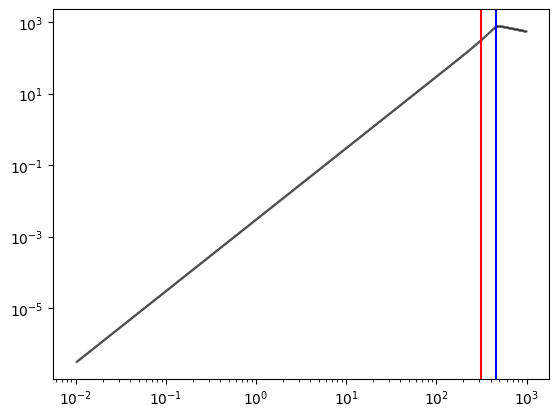

0.21544346900318834


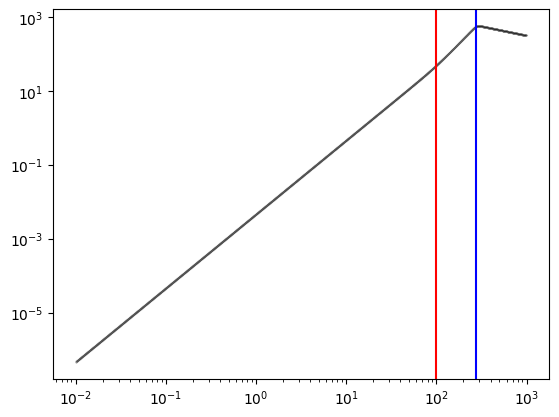

0.46415888336127786


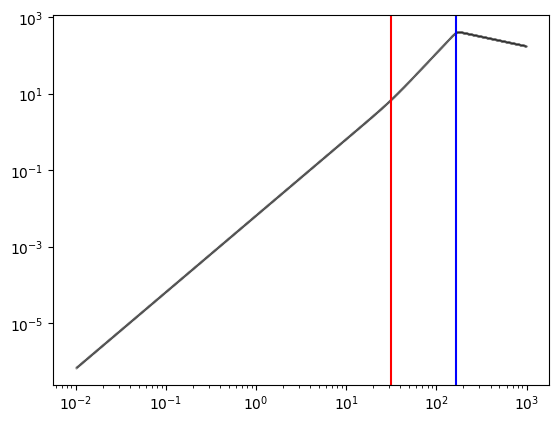

1.0


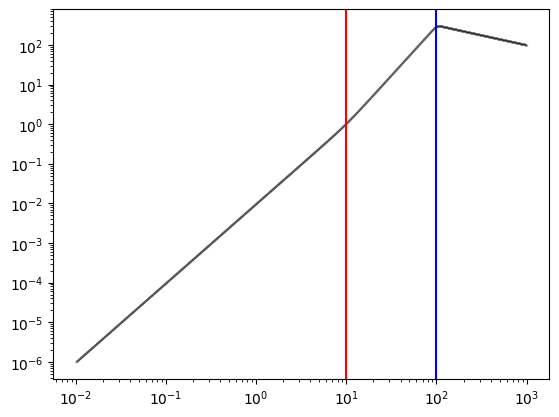

2.1544346900318834


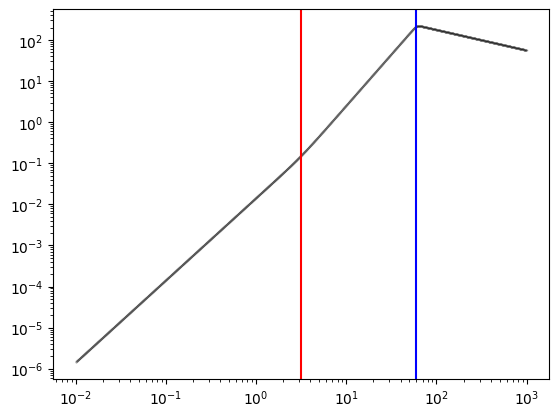

4.6415888336127775


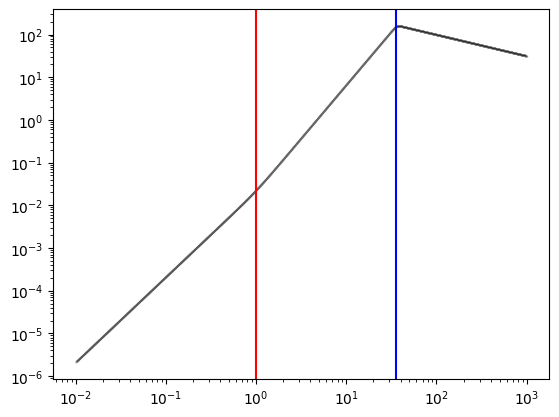

10.0


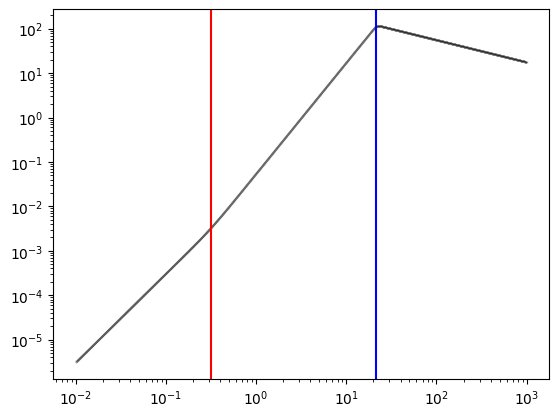

21.54434690031882


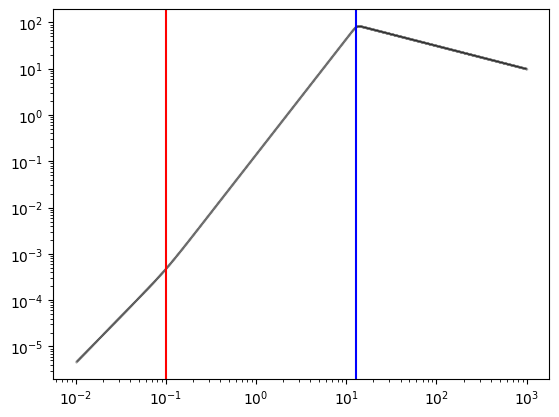

46.41588833612777


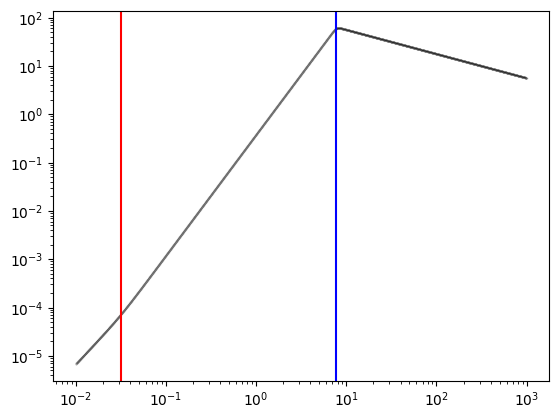

100.0


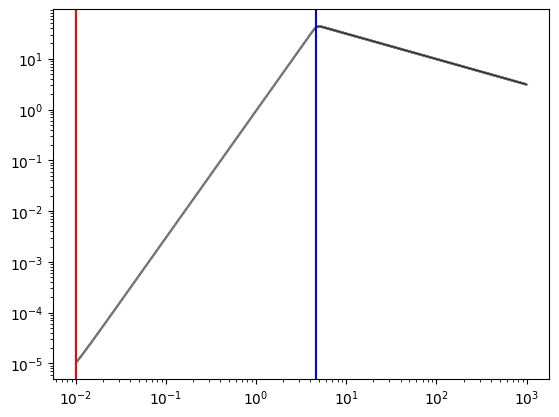

In [6]:
def msbpl(x, amp, xb, a1, a2):
    s = 10
    return amp*((x/xb)**(-a1*s) + (x/xb)**(-a2*s))**(-1/s)
def dsbpl(x,amp,xb1,a1,a2,xb2,a3,s):
    if (a3 < a1) & (a1 < a2):
        result =  amp*(((x/xb1)**(a1*s) + (x/xb1)**(a2*s))**(-1) + (xb2/xb1)**(-a2*s)*(x/xb2)**(-a3*s))**(-1/s)
    elif (a3 < a2) & (a2 < a1):
        result = amp*((x/xb1)**(-a1*s) + (x/xb1)**(-a2*s) + ((xb1/xb2)**(a2*s))*((x/xb2)**(-a3*s)) )**(-1/s)
    else:
        raise Exception("Unhandled powerlaw index ordering")
    return result
def combinedPL(ivar, f0, nu0_1, nu0_2, a1, b1, b2, c1):
    t, nu = ivar
    s=10
    res = []
    t0 = 1
    c2 = 5/2
    c3 = -1/2
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        num = nu0_1*(tval/t0)**b1
        nua = nu0_2*(tval/t0)**b2
        fpk = fnu_m*(num/nua)**(3)
        result = dsbpl(nuval,fpk,num,c1,c2,nua,c3,s)
        res.append(result)
    return num, nua, np.array(res)
def wrap_sbpl(t,amp, tb, a1, a2):
    d=0.2
    f = sbpl(amplitude=amp, x_break=tb, alpha_1=-a1, alpha_2=-a2, delta=d)
    return f(t)
for tval in np.geomspace(0.1,100,num=10):
    fig = plt.figure()
    nu = np.geomspace(1e-2,1000,num=10000)
    t = np.full(nu.shape,tval)
    ivar = (t,nu)
    num, nua, y = combinedPL(ivar, 1e3, 10, 100, 0, -3/2, -2/3, 2)
    # def powerlaw(x,f0,a1):
    #     x_break=1
    #     return f0*(x/x_break)**a1
    # popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
    # popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
    # initial_guess = [10,5,2,5/2]
    # bounds = [(1,1e6),(t.min(),t.max()),(-4,4),(-4,4)]
    # bounds0 = tuple([b[0] for b in bounds])
    # bounds1 = tuple([b[1] for b in bounds])
    # bounds = [bounds0,bounds1]
    
    # popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
    plt.scatter(nu,y,color='black',s=0.1, alpha=0.05)
    # plt.scatter(t[::10], wrap_sbpl(t[::10],1e2,5.7,2,2.5))
    ax = plt.gca()
    ax.axvline(num,color='red')
    ax.axvline(nua,color='blue')
    ax.set_xscale('log')
    ax.set_yscale('log')
    print(tval)
    plt.show()
    plt.close()

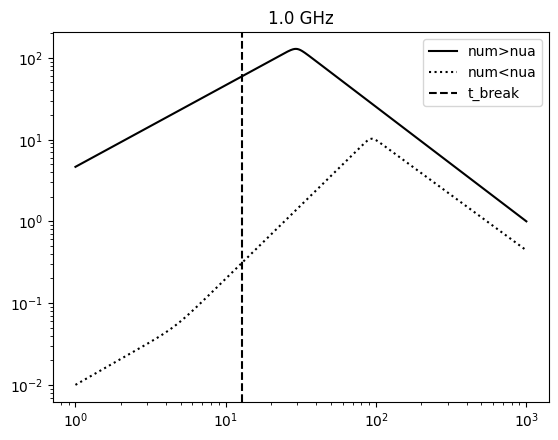

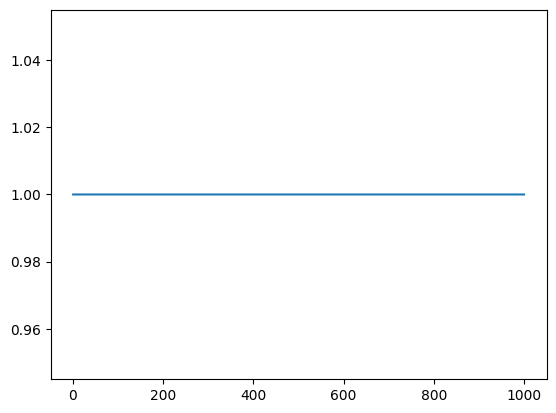

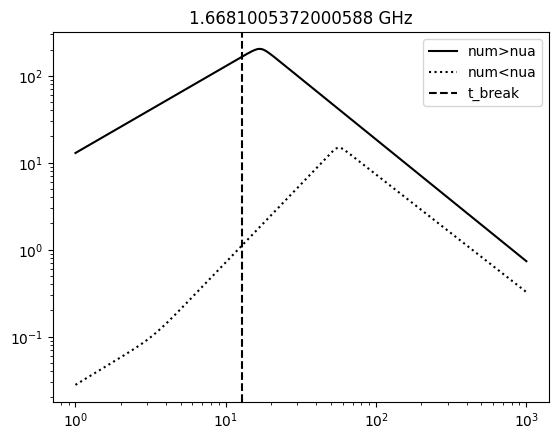

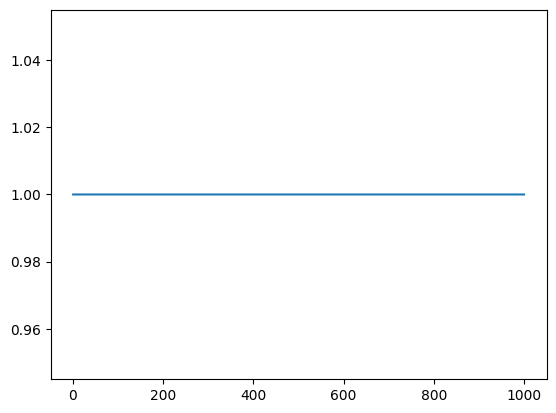

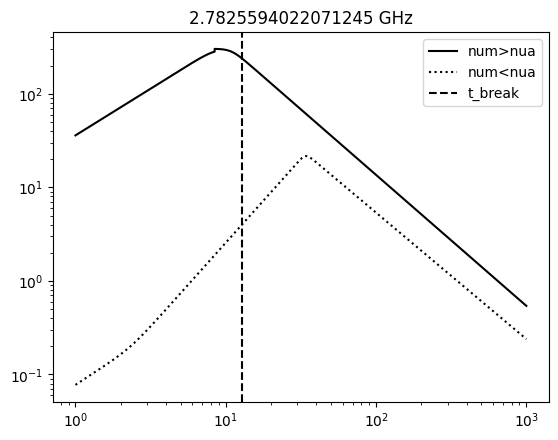

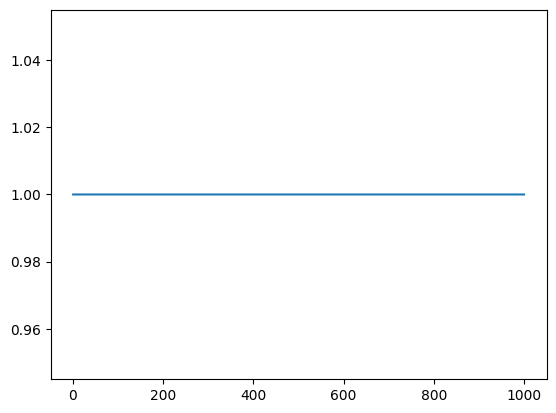

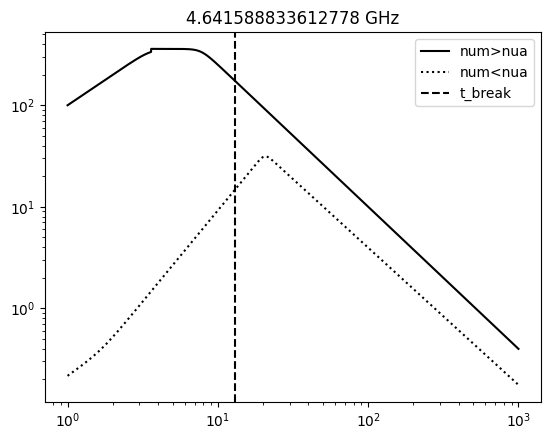

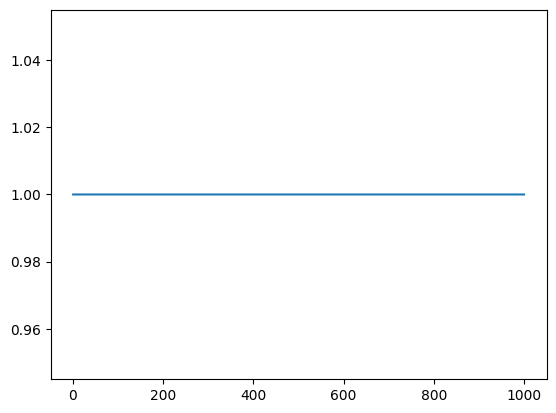

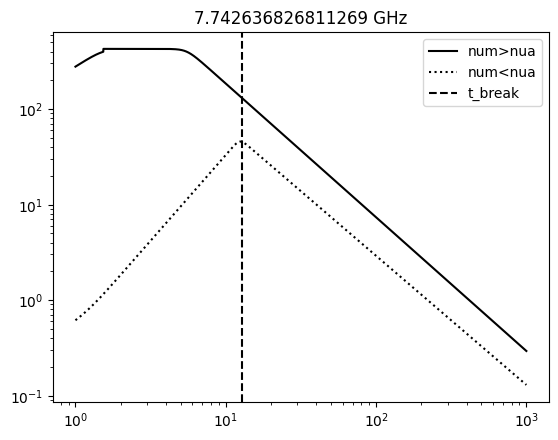

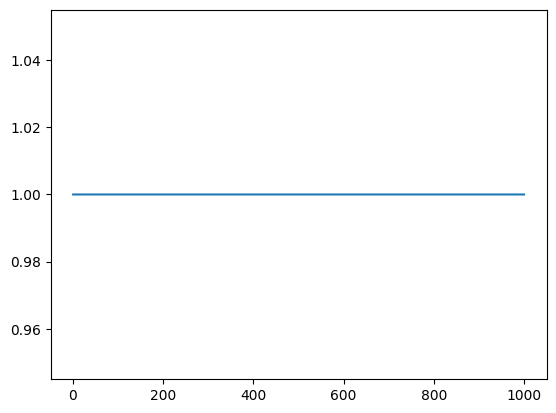

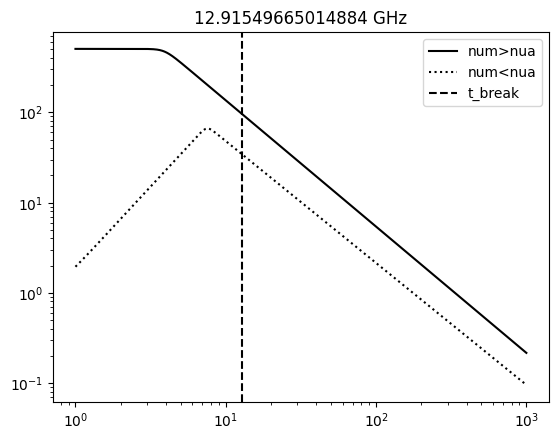

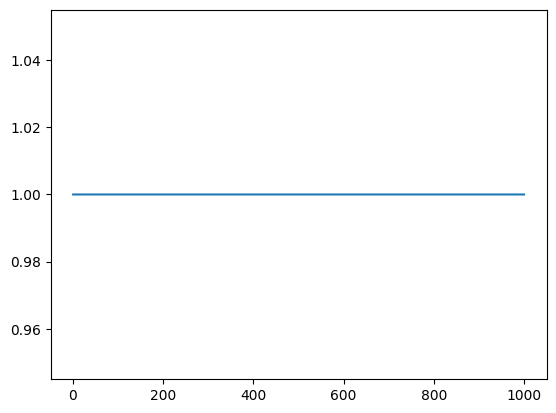

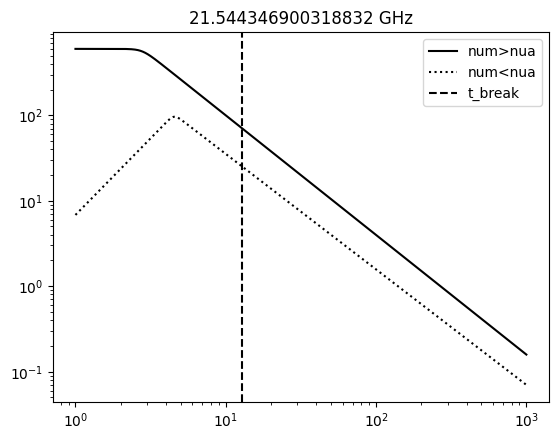

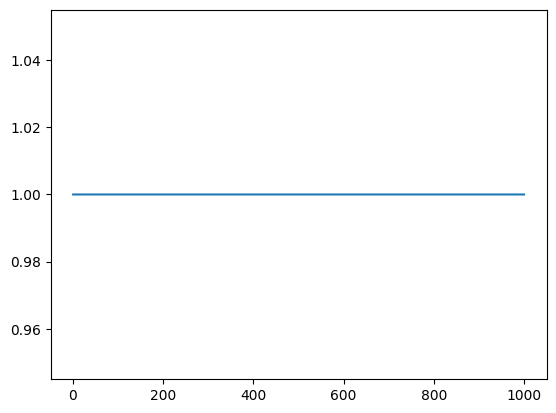

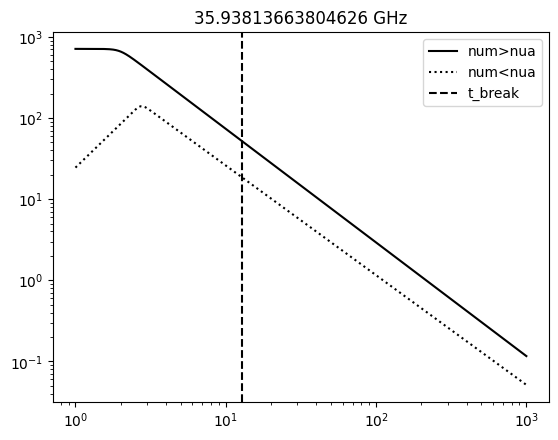

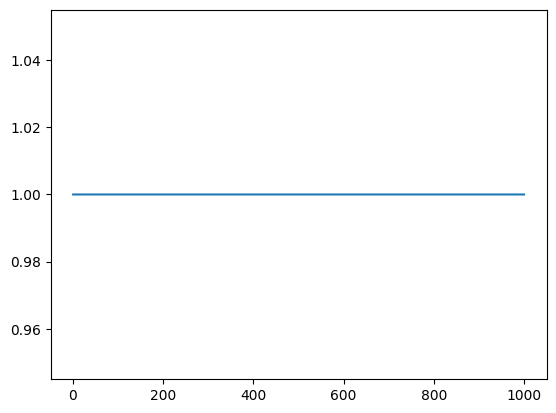

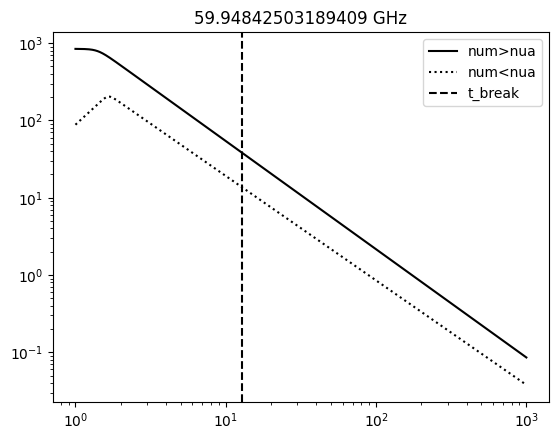

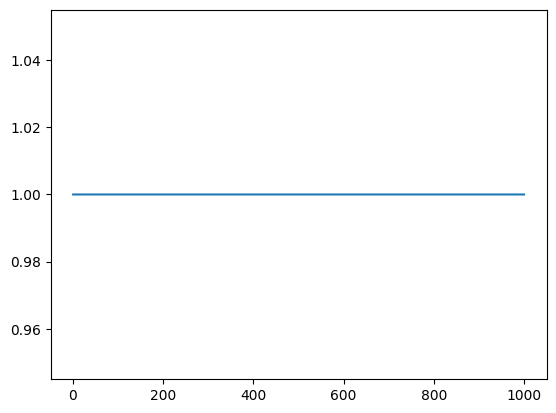

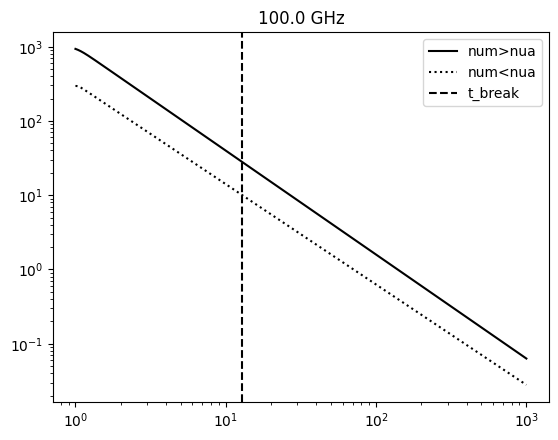

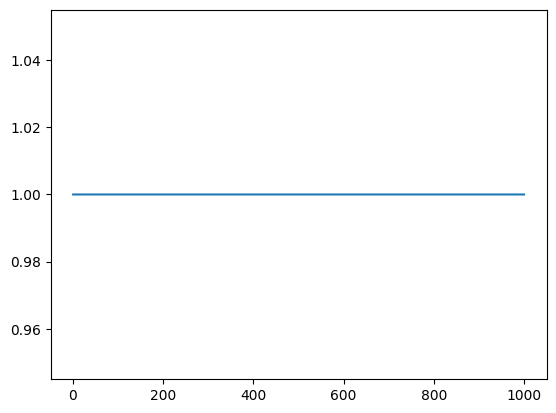

In [9]:
def combinedPL(ivar, f0, nu0_1, nu0_2, k):
    t0 = 1
    d=0.4
    s = 10
    a1 = -k/(2*(4-k))
    b1 = -3*k/(5*(4-k))
    b2 = -3/2
    p = 2.2
    nu0_3 = 1e9
    t, nu = ivar
    y1 = []
    y2 = []
    y3 = []
    t_break = np.amax(t)
    for tval in np.sort(t):
        nua = nu0_1*(tval/t0)**b1
        num = nu0_2*(tval/t0)**b2
        if num <= nua:
            t_break = tval
            break
    for tval,nuval in zip(t,nu):
        b1_1 = -3*k/(5*(4-k))
        b2_1 = -3/2
        b3_1 = -(4-3*k)/(2*(4-k))
        nua_1 = nu0_1*(tval/t0)**b1_1
        num_1 = nu0_2*(tval/t0)**b2_1
        nuc_1 = nu0_3*(tval/t0)**b3_1
        if nuval < nua_1:
            c1_1 = 2
            c2_1 = 1/3
            c3_1 = -(p-1)/2
            fnu_m1 = f0*(tval/t0)**a1
            fpk_1 = fnu_m1*(nua_1/num_1)**(1/3)
            nubreak1_1 = nua_1
            nubreak2_1 = num_1
        else:
            fnu_m1 = f0*(tval/t0)**a1
            c1_1 = 1/3
            c2_1 = -(p-1)/2
            c3_1 = -1
            fpk_1 = f0*(tval/t0)**a1
            nubreak1_1 = num_1
            nubreak2_1 = nuc_1
        a1_2 = -k/(2*(4-k))
        b1_2 = -3/2
        b2_2 = -(12*p+8-3*p*k+2*k)/(2*(4-k)*(p+4))
        c1_2 = 2
        c2_2 = 5/2
        c3_2 = -(p-1)/2
        # At t_break num==nua, determines the normalization of these values.
        num_2 = nu0_1*(tval/t0)**b1_2
        nua_2 = nu0_2*(tval/t0)**b2_2
        num_break2 = nu0_1*(t_break/t0)**b1_2
        nua_break2 = nu0_2*(t_break/t0)**b2_2
        fnu_m_2 = f0*(tval/t0)**a1_2
        fpk = fnu_m_2*(num_2/nua_2)**(3)
        fpk_2 = fpk
        res1 = dsbpl(nuval,fpk_1,nubreak1_1,c1_1,c2_1,nubreak2_1,c3_1,s)

        c1_1 = 2
        c2_1 = 1/3
        c3_1 = -(p-1)/2
        num_1 = nu0_1*(t_break/t0)**b1_1
        nua_1 = nu0_2*(t_break/t0)**(b2_1)
        fnu_m1 = f0*(t_break/t0)**a1
        fpk_1 = fnu_m1*(nua_1/num_1)**(1/3)
        # F_bk1 = dsbpl(nuval,fpk_1,num_1,c1_1,c2_1,nua_1,c3_1,s)
        # fpk2_break = f0*(t_break/t0)**a1_2*(num_break2/nua_break2)**(3)
        # F_bk2 = dsbpl(nuval,fpk2_break,num_break2,c1_2,c2_2,nua_break2,c3_2,s)
        # res2 = F_bk1*dsbpl(nuval,fpk_2,num_2,c1_2,c2_2,nua_2,c3_2,s)/F_bk2
        res2 = dsbpl(nuval,fpk_2,num_2,c1_2,c2_2,nua_2,c3_2,s)
        res3 = dsbpl(nuval,fpk_2,num_2,c1_2,c2_2,nua_2,c3_2,s)
        y1.append(res1)
        y2.append(res2)
        y3.append(res2/res3)
    return np.array(y1), np.array(y2), np.array(y3), t_break

fig = plt.figure()
t = np.geomspace(1,1e3,num=10000)
for nuval in np.geomspace(1,100,num=10):
    nu = np.full(t.shape,nuval)
    ivar = (t,nu)
    y1 ,y2, y3, tbk = combinedPL(ivar, 1e3, 10, 100,2)
    # def powerlaw(x,f0,a1):
    #     x_break=1
    #     return f0*(x/x_break)**a1
    # popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
    # popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
    # initial_guess = [y.max(),np.median(t),0.5,-1]
    # bounds = [(1,1e6),(t.min(),t.max()),(0.01,2),(-4,-0.01)]
    # bounds0 = tuple([b[0] for b in bounds])
    # bounds1 = tuple([b[1] for b in bounds])
    # bounds = [bounds0,bounds1]
    
    # popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
    # plt.scatter(t[::10], msbpl(t[::10],*popt))
    plt.plot(t,y1,color='black', alpha=1,label="num>nua")
    plt.plot(t,y2,color='black', ls=':', alpha=1,label="num<nua")
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axvline(tbk,color='black',ls='--',alpha=1,label="t_break")
    ax.set_title(f"{nuval} GHz")
    ax.legend()
    plt.show()
    plt.close()
    fig = plt.figure()
    plt.plot(t,y3)
    ax = plt.gca()
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    plt.show()
    plt.close()

In [62]:
def reverse_shock(ivar, f0, t0, nu0_1,nu0_2):
    t, nu = ivar
    s=10
    res = []
    p=2
    nu0_1 = 1
    nu0_2 = 15
    nu0_3 = 1e9
    k=2
    a1 = -(47-10*k)/(12*(4-k))
    b1 = -(32-7*k)/(15*(4-k))
    b2 = -(73-14*k)/(12*(4-k))
    b3 = -(73-14*k)/(12*(4-k))
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        nua = nu0_1*(tval/t0)**b1
        num = nu0_2*(tval/t0)**b2
        nuc = nu0_3*(tval/t0)**b3
        if nuval < nua:
            c1 = 2 
            c2 = 1/3
            c3 = -(p-1)/2
            fpk = fnu_m*(nua/num)**(1/3)
            result = dsbpl(nuval,fpk,nua,c1,c2,num,c3,s)
        else:
            c1 = 1/3
            c2 = -(p-1)/2
            c3 = -(p-1)/2 - 0.1
            fpk = fnu_m
            result = dsbpl(nuval,fpk,num,c1,c2,nuc,c3,s)
        res.append(result)
    return np.array(res)
def wrap_bigsbpl(ivar, f0, frev, trev,nu0_1rev,nu0_2rev,nu0, t_nonrel,k):
    t0 = 1
    s = 10
    d = 0.2
    a1 = -k/(2*(4-k))
    a2 =(3-2*k)/(5-k)
    b1 =-(3*k)/(5*(4-k))
    c1 =2
    c2 = -0.6  
    t, nu = ivar
    res = []
    frev = reverse_shock(ivar, frev, trev, nu0_1rev, nu0_2rev)
    for tval,nuval in zip(t,nu):
        fpk =  sbpl(amplitude=f0, x_break=t_nonrel, alpha_1=-a1, alpha_2=-a2, delta=d)(tval)
        nupk = nu0*(tval/t0)**b1
     #    nupk2 = nu0*(tval/t0)**b2
        f = sbpl(amplitude=fpk, x_break=nupk, alpha_1=-c1, alpha_2=-c2, delta=d)
        # f = sbpl(amplitude=fpk, x_break=nupk, alpha_1=-c1, alpha_2=-c2, delta=d)
        # res1 = dsbpl(nuval,fpk_1,nubreak1_1,c1_1,c2_1,nubreak2_1,c3_1,s)
        t0_rev = 0.05
        res.append(f(nuval))
    return frev + np.array(res)

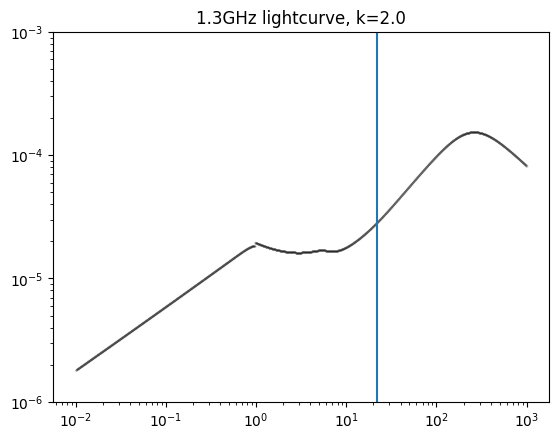

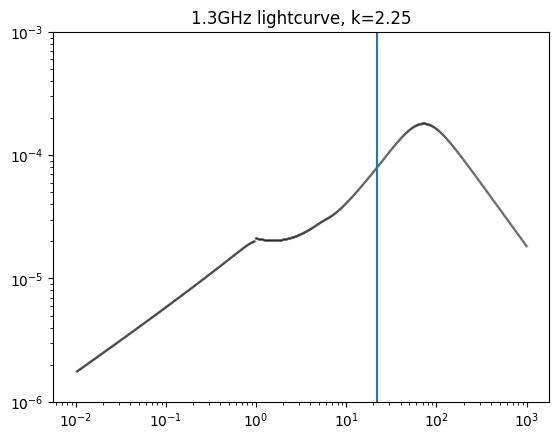

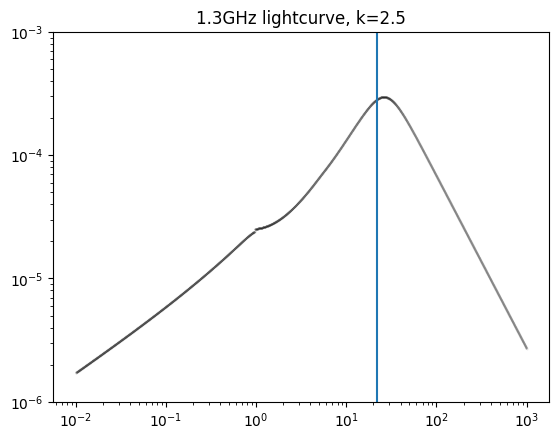

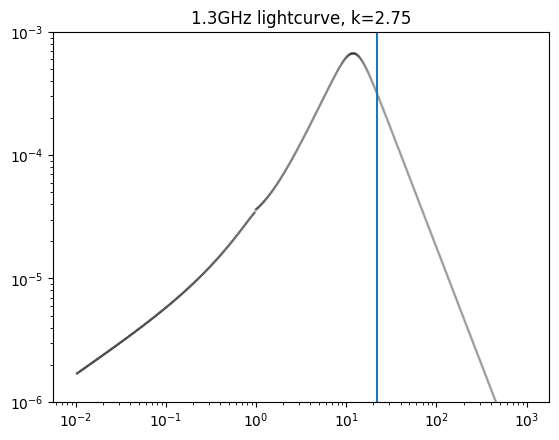

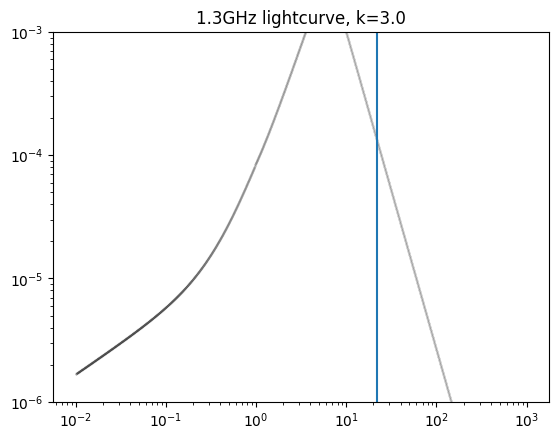

In [63]:
fig = plt.figure()
ylast=0
for k in np.linspace(2,3,num=5):
    nuval=1.3
    t = np.geomspace(1e-2,1000,num=10000)
    nu = np.full(t.shape,nuval)
    ivar = (t,nu)
    y = wrap_bigsbpl(ivar, 3.5e-4,3e-5, 1.5,1.15,44.7,35, 22, k)
    # def powerlaw(x,f0,a1):
    #     x_break=1
    #     return f0*(x/x_break)**a1
    # popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
    # popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
    initial_guess = [1e3,1,0.5,-1]
    bounds = [(1,1e6),(t.min(),t.max()),(-0.01,2),(-4,-0.01)]
    bounds0 = tuple([b[0] for b in bounds])
    bounds1 = tuple([b[1] for b in bounds])
    bounds = [bounds0,bounds1]
    
    # popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
    # print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
    plt.scatter(t,y,color='black',s=0.1, alpha=0.05)
    # plt.scatter(t[::10], msbpl(t[::10],*popt))
    ax = plt.gca()
    ax.axvline(22)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1e-3)
    ax.set_title(f"{nuval}GHz lightcurve, k={k}")
    plt.show()
    plt.close()